In [1]:
import scCube
from scCube import scCube
from scCube.visualization import *
from scCube.utils import *
from matplotlib.pyplot import rc_context
import pandas as pd
import scanpy as sc
import numpy as np
import warnings
import time
warnings.filterwarnings("ignore")

/home/qjy/anaconda3/envs/sccube/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = scCube()

In [3]:
sc_data = pd.read_csv('/home/qjy/workspace/scCube/scCube/tutorial/demo_data/demo_sc_data.csv', index_col=0)
sc_meta = pd.read_csv('/home/qjy/workspace/scCube/scCube/tutorial/demo_data/demo_sc_meta.csv', index_col=0)

sc_adata = model.pre_process(sc_data=sc_data, 
                             sc_meta=sc_meta,
                             is_normalized=False)

the input is count matrix, normalizing it firstly...


In [4]:
model_name = 'demo_epoch10000'
generate_sc_meta, generate_sc_data = model.train_vae_and_generate_cell(
    sc_adata=sc_adata,
    celltype_key='Cell_type',
    cell_key='Cell',
    target_num=None,
    batch_size=512,
    epoch_num=10000,
    lr=0.0001,
    hidden_size=128,
    save_model=True,
    save_path='/home/qjy/workspace/scCube/save_model',
    project_name=model_name,
    used_device='cuda:1')

generating by the proportion of cell types of the input scRNA-seq data...
begin vae training...


Train Epoch: 9999: 100%|██████████| 10000/10000 [01:36<00:00, 103.11it/s, loss=0.1234, min_loss=0.1229]


vae training done!
saving the trained vae model...
save trained vae in /home/qjy/workspace/scCube/save_model/demo_epoch10000.pth.


Generate Epoch: 0: 100%|██████████| 408/408 [00:00<00:00, 45972.38it/s]

generated done!
data have been prepared!


In [5]:
sc.pp.highly_variable_genes(sc_adata, flavor="seurat_v3", n_top_genes=2000)
sc_adata = sc_adata[:, sc_adata.var.highly_variable]
sc.pp.scale(sc_adata, max_value=10)
sc.tl.pca(sc_adata, svd_solver='arpack')
sc.pp.neighbors(sc_adata)
sc.tl.umap(sc_adata)

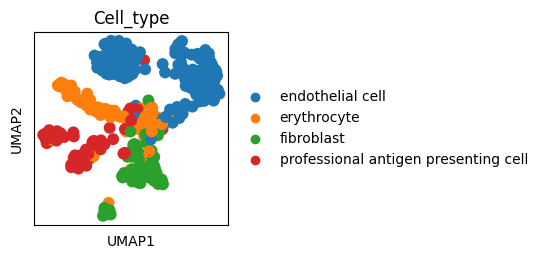

In [6]:
with rc_context({'figure.figsize': (2.5, 2.5)}):
    sc.pl.umap(sc_adata, color='Cell_type')

In [7]:
sc_adata_generate = model.pre_process(sc_data=generate_sc_data, 
                                      sc_meta=generate_sc_meta,
                                      is_normalized=True)

sc.pp.highly_variable_genes(sc_adata_generate, flavor="seurat_v3", n_top_genes=2000)
sc_adata_generate = sc_adata_generate[:, sc_adata_generate.var.highly_variable]
sc.pp.scale(sc_adata_generate, max_value=10)
sc.tl.pca(sc_adata_generate, svd_solver='arpack')
sc.pp.neighbors(sc_adata_generate)
sc.tl.umap(sc_adata_generate)

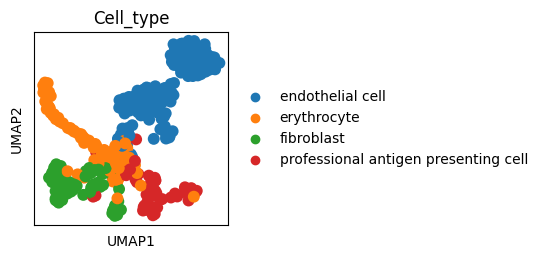

In [8]:
with rc_context({'figure.figsize': (2.5, 2.5)}):
    sc.pl.umap(sc_adata_generate, color='Cell_type')

In [9]:
adata_concat = sc_adata.concatenate(sc_adata_generate, batch_categories=['real', 'generate'])
sc.tl.pca(adata_concat)
# sc.external.pp.bbknn(adata_concat, batch_key='batch')  # running bbknn 1.3.6
sc.pp.neighbors(adata_concat)
sc.tl.umap(adata_concat)

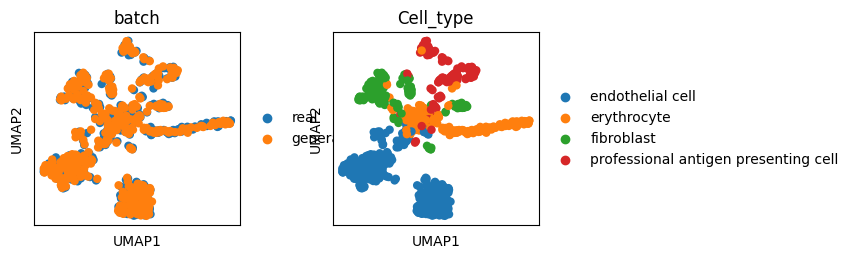

In [10]:
with rc_context({'figure.figsize': (2.5, 2.5)}):
    sc.pl.umap(adata_concat, color=['batch', 'Cell_type'])

In [11]:
# generate cell coordinates
# image-based 3d
generate_sc_data, generate_sc_meta_new, st_data, st_meta, st_index = model.generate_spatial_data_random(
    generate_sc_data=generate_sc_data,
    generate_sc_meta=generate_sc_meta,
    set_seed=True,
    seed=12345,
    spatial_cell_type=None,
    spatial_dim=3,
    spatial_size=20,
    delta=20,
    gamma=0.75,
    is_spot=False,
    gene_type='hvg',
    min_cell=10,
    n_gene=500,
    is_split=True,
    split_coord='point_z',
    slice_num=5,
)


generating spatial coordinates of single cells...
generating spatial patterns of totally 4 cell types...
generating image-based ST data with 500 targeted genes...
generating image-based data with 500 targeted HVGs...


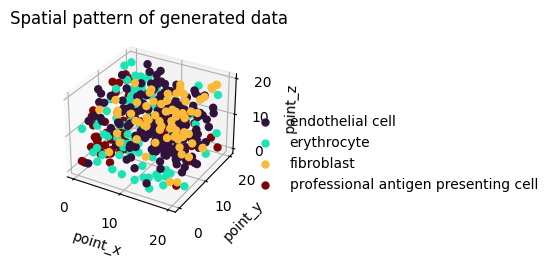

In [12]:
plot_spatial_pattern_scatter(
    obj=generate_sc_meta_new,
    figwidth=2.5,
    figheight=2.5,
    dim=3,
    x="point_x",
    y="point_y",
    z="point_z",
    label='Cell_type',
    colormap='turbo',
    size=25,
    alpha=1)
plt.show()

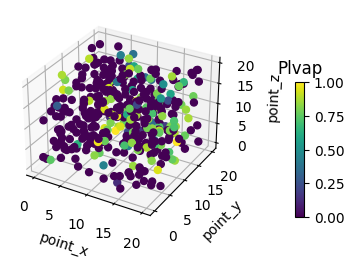

In [13]:
plot_gene_scatter(
    data=generate_sc_data,
    obj=generate_sc_meta_new,
    figwidth=3,
    figheight=2.5,
    dim=3,
    label='Cell',
    normalize=True,
    x="point_x",
    y="point_y",
    z="point_z",
    show_gene="Plvap",
    colormap='viridis',
    size=25,
    alpha=1
)
plt.show()

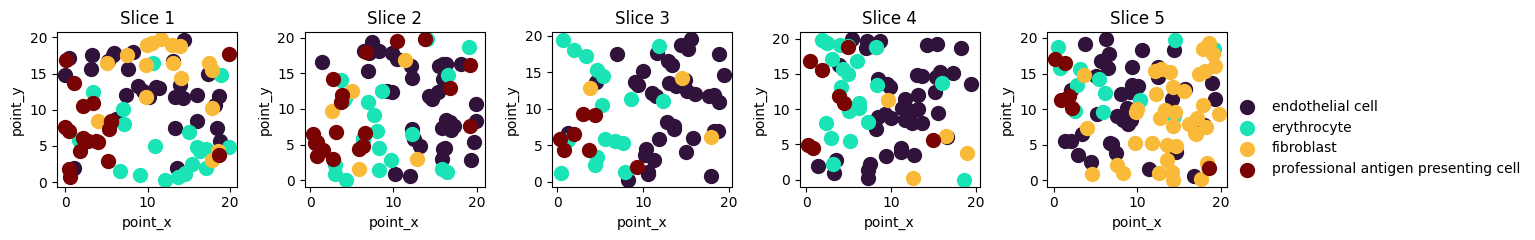

In [14]:
plot_slice_scatter(
    obj=generate_sc_meta_new,
    figwidth=12.5,
    figheight=2.5,
    x="point_x",
    y="point_y",
    label='Cell_type',
    colormap='turbo',
    size=100,
    alpha=1
)
plt.show()

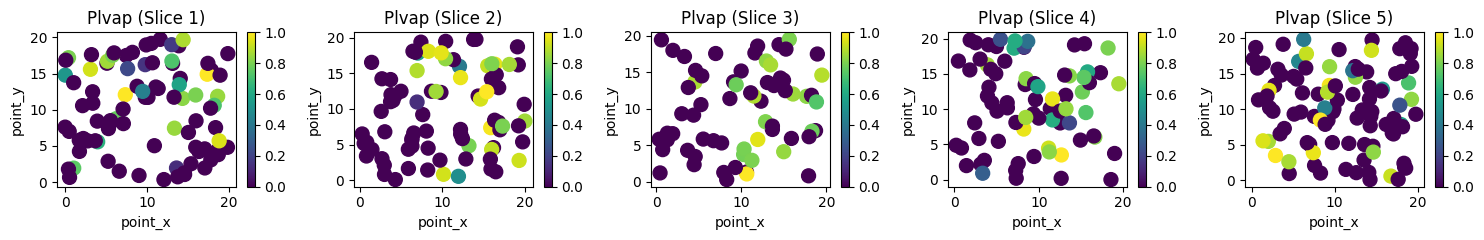

In [18]:
generate_sc_meta_new.reset_index(drop = True,inplace = True)
plot_slice_gene_scatter(
    data=generate_sc_data,
    obj=generate_sc_meta_new,
    figwidth=15,
    figheight=2.5,
    normalize=True,
    x="point_x",
    y="point_y",
    show_gene="Plvap",
    colormap='viridis',
    size=100,
    alpha=1

)
plt.show()